***Task1***

In [1]:
import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
display.set_matplotlib_formats("svg")

In [2]:
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")

In [3]:
df1.drop(['Name','Ticket','Cabin','Embarked'],axis=1,inplace=True)
df2.drop(['Name','Ticket','Cabin','Embarked'],axis=1,inplace=True)

Make the gender numerical. 
male-0,
female-1

In [4]:
lst1 = [0 if gen=="male" else 1 for gen in df1['Sex']]
lst2 = [0 if gen=="male" else 1 for gen in df2['Sex']]

df1['Sex'] = lst1
df2['Sex'] = lst2

In [5]:
lst = df1.columns.tolist()
lst = lst[:1]+lst[2:]+lst[1:2]
df1=df1[lst]
df1.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,1,3,0,22.0,1,0,7.2500,0
1,2,1,1,38.0,1,0,71.2833,1
2,3,3,1,26.0,0,0,7.9250,1
3,4,1,1,35.0,1,0,53.1000,1
4,5,3,0,35.0,0,0,8.0500,0
5,6,3,0,NaN,0,0,8.4583,0
6,7,1,0,54.0,0,0,51.8625,0
7,8,3,0,2.0,3,1,21.0750,0
8,9,3,1,27.0,0,2,11.1333,1
9,10,2,1,14.0,1,0,30.0708,1


There are NaNs in the 'Age' columnn. So we fill them with mean of the column

In [6]:
m = df1['Age'].mean()
df1['Age'].fillna(value=m, inplace=True)
df1.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,1,3,0,22.000000,1,0,7.2500,0
1,2,1,1,38.000000,1,0,71.2833,1
2,3,3,1,26.000000,0,0,7.9250,1
3,4,1,1,35.000000,1,0,53.1000,1
4,5,3,0,35.000000,0,0,8.0500,0
5,6,3,0,29.699118,0,0,8.4583,0
6,7,1,0,54.000000,0,0,51.8625,0
7,8,3,0,2.000000,3,1,21.0750,0
8,9,3,1,27.000000,0,2,11.1333,1
9,10,2,1,14.000000,1,0,30.0708,1


We split our train.csv into training data and testing data in 80:20 split

In [7]:
X = torch.tensor(df1.drop("Survived", axis=1).values, dtype=torch.float)
y = torch.tensor(df1["Survived"].values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([712, 7]) torch.Size([712])
torch.Size([179, 7]) torch.Size([179])


In [8]:
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
len(test_data.tensors[0])

179

We write a custom Linear layer class

In [9]:
class MyLinear(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        # initialize weights and biases
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init

    def forward(self, x):
        w_times_x= torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  # w times x + b
        

In our custom model class we have 1 input layer, 2 hidden layers, 1 output layer

In [10]:
class Net(nn.Module):
    def __init__(self,inp,hidd1,hidd2,out):
        super().__init__()
        self.input = MyLinear(inp, hidd1)
        self.hidden_1 = MyLinear(hidd1, hidd2)
        self.output = MyLinear(hidd2, out)
        
    def forward(self, x):
        x = self.input(x)
        x = self.hidden_1(x)
        x = self.output(x)
        return x
    
    
model = Net(7,20,25,2)
print(model)

Net(
  (input): MyLinear()
  (hidden_1): MyLinear()
  (output): MyLinear()
)


**Training our model**

We chose crossentropy as our criterion for loss function

In [11]:
num_epochs = 200
train_accuracies, test_accuracies = [], []

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    lst=[]
    for X, y in train_loader:
        preds = model(X)
        pred_labels = torch.argmax(preds, axis=1)
        y=y.squeeze().long()
        
        loss = loss_function(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy = 100 * torch.mean((pred_labels == y).float()).item()
        lst.append(train_accuracy)
#         if(epoch>=198):
#             print("Prediction:",pred_labels,"Actual:",y,"Accuracy:",train_accuracy)
    train_accuracies.append(np.mean(lst))


    
#     Test set
    X, y = next(iter(test_loader))
    pred_labels = torch.argmax(model(X), axis=1)
    test_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )

Plots of accuracy vs epochs

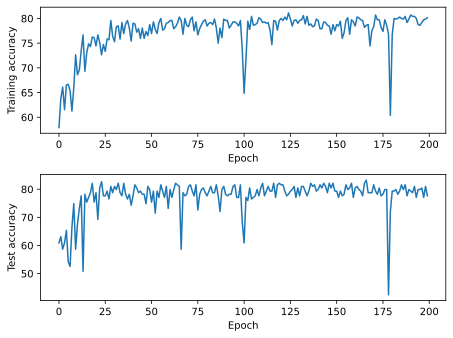

In [12]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test accuracy")

fig.align_labels()
plt.show()

In [13]:
np.mean(train_accuracies)

77.40069440826774

In [14]:
np.mean(test_accuracies)

77.60335168242455

There is an average accuracy of 77% in our model

In [15]:
X = torch.tensor(df2.values, dtype=torch.float)
print(X.shape)

torch.Size([418, 7])


In [16]:
preds = model(X)
pred_labels1 = torch.argmax(preds, axis=1)
pred_labels1

tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,

These are our predictions on **test.csv**

In [17]:
df = pd.read_csv("test.csv")
df['Survived']=pred_labels1

In [18]:
df.head(20)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0


**Task2**


Significant variables (in order of significance) include: gender, number_siblings_abroas, ticket_class, and number_parents_abroad

We rerun our regression based on these 4 variables only as only they have a not so bad statistical significance



In [19]:
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")

Since the variables which have a statistical significance are

*   Pclass
*   Sex
*   SibSp
*   Parch

We consider only these 4 varibles in out input layer










In [20]:
df1.drop(['Name','Ticket','Cabin','Embarked','PassengerId','Age','Fare'],axis=1,inplace=True)
df2.drop(['Name','Ticket','Cabin','Embarked','PassengerId','Age','Fare'],axis=1,inplace=True)

In [21]:
df1.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,male,1,0
1,1,1,female,1,0
2,1,3,female,0,0
3,1,1,female,1,0
4,0,3,male,0,0


In [22]:
lst1 = [0 if gen=="male" else 1 for gen in df1['Sex']]
lst2 = [0 if gen=="male" else 1 for gen in df2['Sex']]

df1['Sex'] = lst1
df2['Sex'] = lst2

In [23]:
X = torch.tensor(df1.drop("Survived", axis=1).values, dtype=torch.float)
y = torch.tensor(df1["Survived"].values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([712, 4]) torch.Size([712])
torch.Size([179, 4]) torch.Size([179])


In [24]:
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
len(test_data.tensors[0])

179

In [25]:
class MyLinear(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        # initialize weights and biases
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init

    def forward(self, x):
        w_times_x= torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  # w times x + b

In [26]:
class Net2(nn.Module):
    def __init__(self,inp,hidd1,hidd2,out):
        super().__init__()
        self.input = MyLinear(inp, hidd1)
        self.hidden_1 = MyLinear(hidd1, hidd2)
        self.output = MyLinear(hidd2, out)
        
    def forward(self, x):
        x = self.input(x)
        x = self.hidden_1(x)
        x = self.output(x)
        return x
    
    
model = Net2(4,20,25,2)
print(model)

Net2(
  (input): MyLinear()
  (hidden_1): MyLinear()
  (output): MyLinear()
)


In [27]:
num_epochs = 200
train_accuracies, test_accuracies = [], []

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    lst=[]
    for X, y in train_loader:
        preds = model(X)
        pred_labels = torch.argmax(preds, axis=1)
        y=y.squeeze().long()
        
        loss = loss_function(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy = 100 * torch.mean((pred_labels == y).float()).item()
        lst.append(train_accuracy)
#         if(epoch>=198):
#             print("Prediction:",pred_labels,"Actual:",y,"Accuracy:",train_accuracy)
    train_accuracies.append(np.mean(lst))


    
#     Test set
    X, y = next(iter(test_loader))
    pred_labels = torch.argmax(model(X), axis=1)
    test_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )

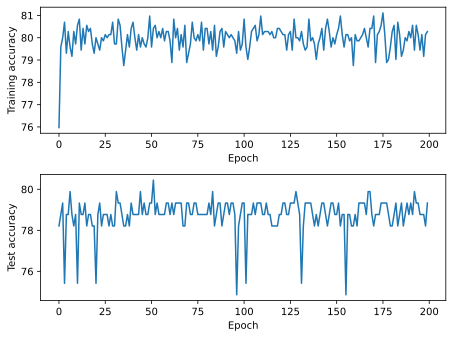

In [28]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test accuracy")

fig.align_labels()
plt.show()

In [29]:
np.mean(train_accuracies)

79.98333333084982

In [30]:
np.mean(test_accuracies)

78.7877089381218

Our accuracy increased from 77% to 79%.

So considering only the variables which have statistical significance does better the model

In [31]:
X = torch.tensor(df2.values, dtype=torch.float)
print(X.shape)

torch.Size([418, 4])


In [32]:
preds = model(X)
pred_labels2 = torch.argmax(preds, axis=1)
pred_labels2

tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

These are our new predictions on **test.csv**

In [33]:
df = pd.read_csv("test.csv")
df['Survived']=pred_labels2

In [34]:
df.head(20)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0
